In [218]:
import numpy as np
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearnex import patch_sklearn, config_context
patch_sklearn()
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import plotly.express as px


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [219]:
past = 'DataSet/Final/DataSet2017_2021.csv'
df = pd.read_csv(past, delimiter = ';',  low_memory=False, encoding='UTF-8', index_col = False)
df.columns

Index(['data_inversa', 'dia_semana', 'horario', 'uf', 'br', 'km', 'municipio',
       'causa_acidente', 'tipo_acidente', 'classificacao_acidente', 'fase_dia',
       'sentido_via', 'condicao_metereologica', 'tipo_pista', 'tracado_via',
       'uso_solo', 'pessoas', 'mortos', 'feridos_leves', 'feridos_graves',
       'ilesos', 'ignorados', 'feridos', 'veiculos', 'latitude', 'longitude',
       'regional', 'delegacia', 'uop', 'ano', 'mes', 'dia', 'mortes'],
      dtype='object')

In [220]:
df = df.convert_dtypes()
df1 = df.copy()
#df1 = df1[(df1['ano'] == 2019) | (df1['ano'] == 2020) | (df1['ano'] == 2021)]

In [221]:
#df2 = df[['uf','causa_acidente', 'tipo_acidente', 'classificacao_acidente', 'sentido_via', 'condicao_metereologica', 'tipo_pista', 'tracado_via','uso_solo', 'latitude', 'longitude']]
df1['uf_br'] = df1['uf'] + '_' + df1['br'].map(str)
var = 'uf'

col = [var, 'tipo_pista', 'causa_acidente', 'tracado_via', 'mortos', 'condicao_metereologica'] # colunas selecionadas

ci = 2
cf = 18

df2 = df1.copy()
df2 = df2[col]
df2 = df2.reset_index(drop=True)
df3 = df2.copy()


In [222]:
l = []

for i in range(1,len(col)): 
    a = df3[[var, col[i]]]
    a = a.groupby([var, col[i]]).size()
    a = a.unstack(level=0)
    l.append(a)

df4 = pd.concat(l, ignore_index=False, join = 'inner')
df4 = df4.fillna(0)
df4 = df4.T

mortos = 0
acidentes = 0
for i in df3['mortos'].unique():
    if i != 0:
        mortos = mortos + df4[i]
    acidentes = acidentes + df4[i]
    
df4 = df4.drop(columns = df3['mortos'].unique())
df4['mortos'] = mortos
df4['acidentes'] = acidentes
df4['Chuva'] = df4['Chuva'].sum(axis=1)
df4['Desvio Temporario'] = df4['Desvio Temporario'].sum(axis=1)
df4 = df4.T.drop_duplicates()
df4 = df4.T

In [223]:
df5 = df4.copy()
df5min = df5.min()
df5max = df5.max()
df5 = (df5 - df5min) / ( df5max - df5min)
#for i in df5.columns.values:
#    print(i)
df5.head()

,Dupla,Multipla,Simples,Acessar A Via Sem Observar A Presenca Dos Outros Veiculos,Acesso Irregular,Acostamento Em Desnivel,Acumulo De Agua Sobre O Pavimento,Acumulo De Areia Ou Detritos Sobre O Pavimento,Acumulo De Oleo Sobre O Pavimento,Afundamento Ou Ondulacao No Pavimento,...,Garoa/Chuvisco,Granizo,Ignorado,Neve,Nevoeiro/Neblina,Nublado,Sol,Vento,mortos,acidentes
uf,,,,,,,,,,,,,,,,,,,,,
AC,0.007009,0.000648,0.003412,0.019305,0.057143,0.00,0.000000,0.066667,0.000000,0.083333,...,0.002112,0.0,0.005571,0.0,0.001808,0.004177,0.005828,0.027778,0.002333,0.003777
AL,0.042457,0.003022,0.099962,0.096525,0.114286,0.15,0.085714,0.133333,0.083333,0.000000,...,0.055438,0.0,0.044568,0.0,0.030741,0.047813,0.040491,0.194444,0.131804,0.068995
AM,0.000000,0.000000,0.003989,0.000000,0.000000,0.05,0.028571,0.066667,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.016275,0.000330,0.003681,0.000000,0.007776,0.000645
AP,0.002053,0.003022,0.000048,0.027027,0.000000,0.00,0.085714,0.133333,0.000000,0.000000,...,0.000000,0.0,0.004178,0.0,0.003617,0.000000,0.000000,0.000000,0.000000,0.000000
BA,0.152956,0.105331,0.616638,0.482625,0.257143,0.40,0.342857,0.533333,0.250000,0.250000,...,0.263464,0.0,0.569638,1.0,0.242315,0.294900,0.385583,0.101852,0.706843,0.390112


In [248]:
cluster = range(ci,cf)
metodo = ['k-means++', 'random']
CHS = []

for j in metodo:
    for i in cluster:
        model = KMeans(n_clusters = i, init=j, max_iter = 1000)
        model.fit(df5)
        CHS.append([j,metrics.calinski_harabasz_score(df5, model.labels_), i])
print('terminou')

terminou


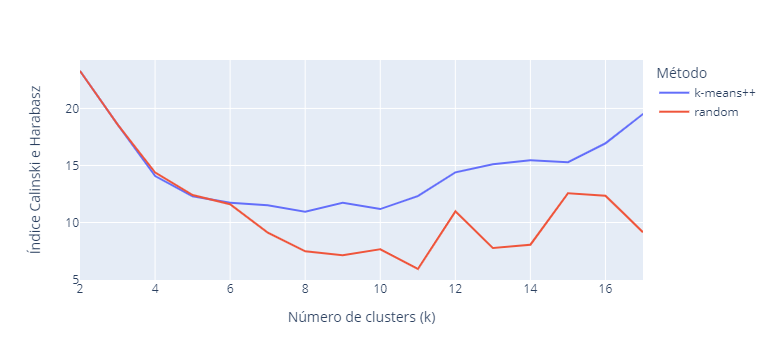

(23.28178399060101, 'k-means++')

In [253]:
CHS2 = pd.DataFrame(CHS, columns = ['meth', 'chs', 'cluster'])
fig = px.line(CHS2, x = 'cluster', y = 'chs', color = 'meth')
fig.update_traces(textposition="bottom right")
fig.update_layout(
    #title="Plot Title",
    xaxis_title="Número de clusters (k)",
    yaxis_title="Índice Calinski e Harabasz",
    legend_title="Método",
)
fig.show()

m = CHS2['chs'].max()
met = CHS2[CHS2['chs'] == m].meth.values[0]
n = CHS2[CHS2['chs'] == m].cluster.values[0]
model = KMeans(n_clusters = n, init=met, max_iter = 1000)
model.fit(df5)

dfresult = df5.copy()
dfresult = dfresult*(df5max - df5min) + df5min
dfresult['cluster'] = model.labels_
m, met

In [279]:
cluster = range(ci,cf)
metodo = ['ward', 'complete', 'average', 'single']
CHS = []
for j in metodo:
    for i in cluster:
        model = AgglomerativeClustering(n_clusters = i, linkage = j )
        model.fit(df5)
        CHS.append([j,metrics.calinski_harabasz_score(df5, model.labels_), i])
print('terminou')

terminou


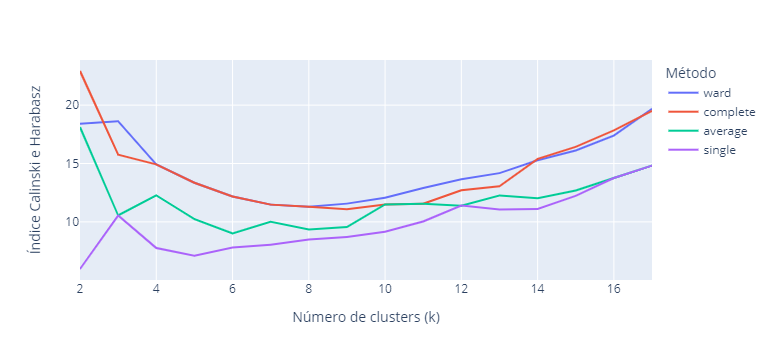

(22.921786628314532, 'complete')

In [280]:
CHS2 = pd.DataFrame(CHS, columns = ['meth', 'chs', 'cluster'])
fig = px.line(CHS2, x = 'cluster', y = 'chs', color = 'meth')
fig.update_traces(textposition="bottom right")
fig.update_layout(
    #title="Plot Title",
    xaxis_title="Número de clusters (k)",
    yaxis_title="Índice Calinski e Harabasz",
    legend_title="Método",
)
fig.show()

m = CHS2['chs'].max()
met = CHS2[CHS2['chs'] == m].meth.values[0]
n = CHS2[CHS2['chs'] == m].cluster.values[0]
model = AgglomerativeClustering(n_clusters = n, linkage = met)
model.fit(df5)

dfresult = df5.copy()
dfresult = dfresult*(df5max - df5min) + df5min
dfresult['cluster'] = model.labels_
m, met

In [312]:
cluster = range(1,5)
metodo = ['ball_tree', 'kd_tree', 'brute']
CHS = []
for j in metodo:
    for i in cluster:
        model = DBSCAN(eps=i, algorithm = j)
        model.fit(df5)
        CHS.append([j,metrics.calinski_harabasz_score(df5, model.labels_), i])
print('terminou')

terminou


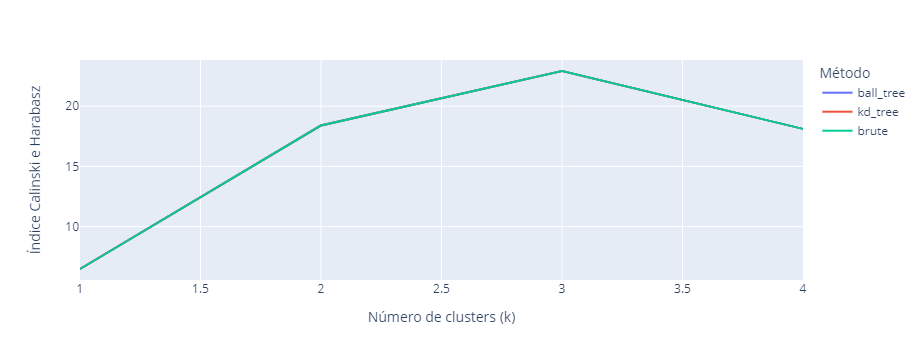

(22.921786628314532, 'ball_tree', 3)

In [313]:
CHS2 = pd.DataFrame(CHS, columns = ['meth', 'chs', 'cluster'])
fig = px.line(CHS2, x = 'cluster', y = 'chs', color = 'meth')
fig.update_traces(textposition="bottom right")
fig.update_layout(
    #title="Plot Title",
    xaxis_title="Número de clusters (k)",
    yaxis_title="Índice Calinski e Harabasz",
    legend_title="Método",
)
fig.show()

m = CHS2['chs'].max()
met = CHS2[CHS2['chs'] == m].meth.values[0]
n = CHS2[CHS2['chs'] == m].cluster.values[0]
model = DBSCAN(eps=n, algorithm = met)
model.fit(df5)

dfresult = df5.copy()
dfresult = dfresult*(df5max - df5min) + df5min
dfresult['cluster'] = model.labels_
m, met, n

In [314]:
cluster = range(2,5)
metodo = ['kmeans', 'random']
CHS = []
for j in metodo:
    for i in cluster:
        model = GaussianMixture(n_components=i, init_params= j)
        model.fit(df5)
        CHS.append([j,metrics.calinski_harabasz_score(df5, model.predict(df5)), i])
print('terminou')

terminou


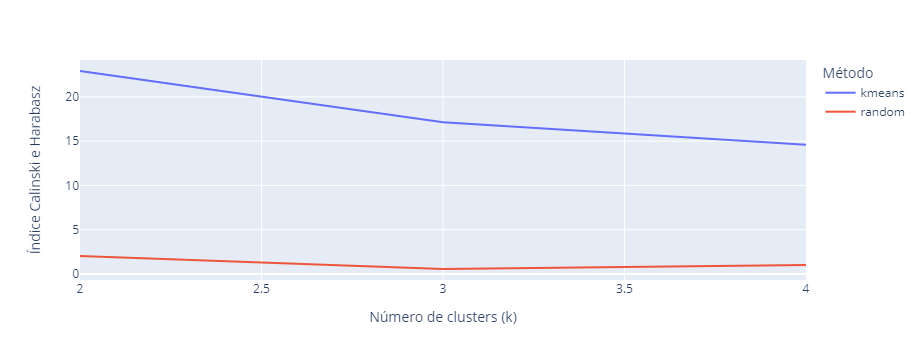

(22.921786628314532, 'kmeans', 2)

In [316]:
CHS2 = pd.DataFrame(CHS, columns = ['meth', 'chs', 'cluster'])
fig = px.line(CHS2, x = 'cluster', y = 'chs', color = 'meth')
fig.update_traces(textposition="bottom right")
fig.update_layout(
    #title="Plot Title",
    xaxis_title="Número de clusters (k)",
    yaxis_title="Índice Calinski e Harabasz",
    legend_title="Método",
)
fig.show()

m = CHS2['chs'].max()
met = CHS2[CHS2['chs'] == m].meth.values[0]
n = CHS2[CHS2['chs'] == m].cluster.values[0]
model = GaussianMixture(n_components=n, init_params= met)
model.fit(df5)

dfresult = df5.copy()
dfresult = dfresult*(df5max - df5min) + df5min
dfresult['cluster'] = model.predict(df5)
m, met, n

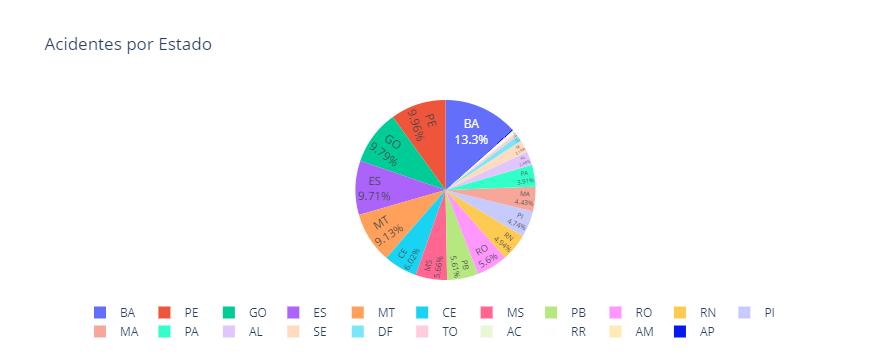

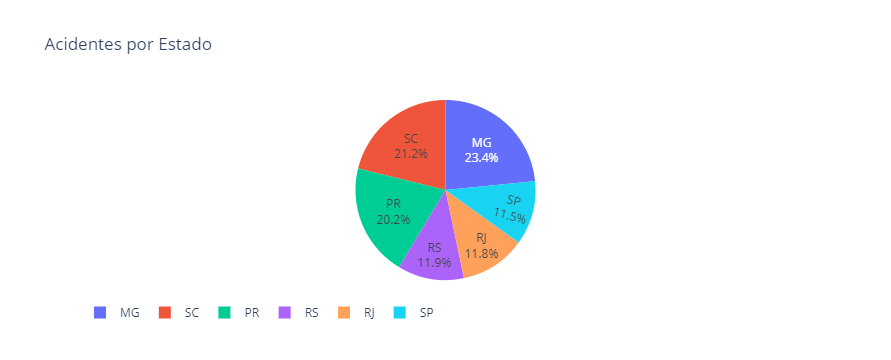

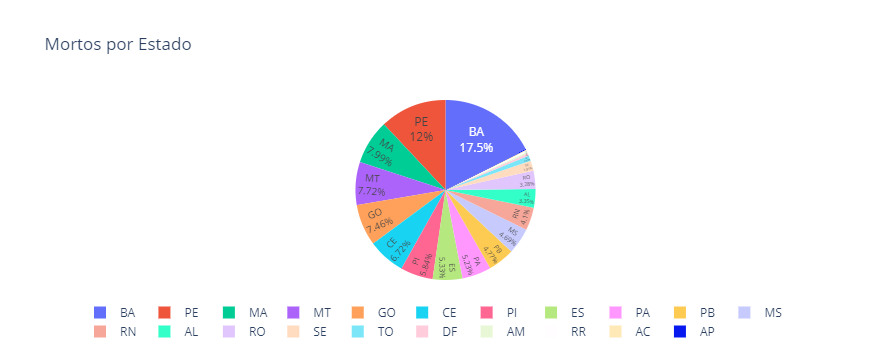

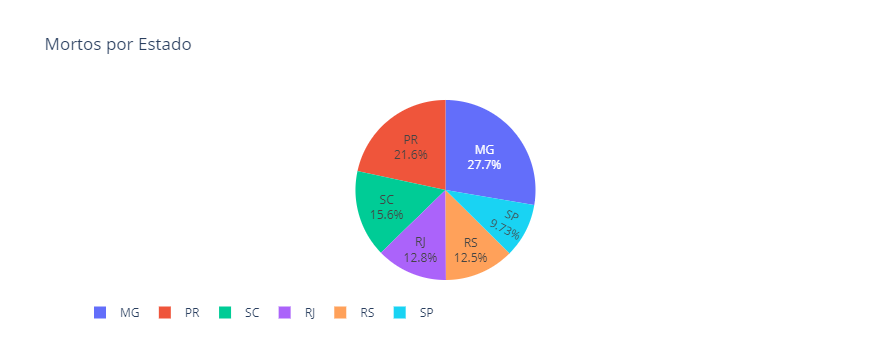

In [228]:
for i in range(0,n):
    dfcluster =dfresult[dfresult['cluster'] == i]
    dfcluster = dfcluster.reset_index()
    #dfcluster['uf'] = dfcluster['uf_br'].str.split('_', expand = True)[0]
    fig = px.pie(dfcluster, names ='uf', values = 'acidentes' , title = 'Acidentes por Estado')
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.update_layout(uniformtext_minsize=12, legend=dict(orientation="h"))
    fig.show()
    
for i in range(0,n):
    
    dfcluster =dfresult[dfresult['cluster'] == i]
    dfcluster = dfcluster.reset_index()
    #dfcluster['uf'] = dfcluster['uf_br'].str.split('_', expand = True)[0]
    fig = px.pie(dfcluster, names ='uf', values = 'mortos', title = 'Mortos por Estado')
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.update_layout(uniformtext_minsize=12, legend=dict(orientation="h"))
    fig.show()
   

In [229]:
dre = []
#for i in df5.columns.values:
    #dfresult[i] = (dfresult[i]/dfresult[i].sum())*100
    
for i in range(0,n):
    #print(str(i))
    d = dfresult[dfresult['cluster']==i]
    d = d.reset_index()
    for j in df5.columns.values:
        a = d[j].sum()
        dre.append(a)
        #print(a, j)
    #print(np.max(dre))

In [ ]:
kkk = []
for i in range(0,n):
    print('cluster', i)
    d = dfresult[dfresult['cluster']==i]
    print(d['mortos'].sum())
    print(d['acidentes'].sum())
    for j in ['tipo_pista', 'causa_acidente', 'tracado_via', 'condicao_metereologica']:
        col2 = pd.unique(df1[j])
        #print('\n')
        #print('Atributos ', j)
        l = []
        a = 0
        for z in col2:
            a = a + d[z].sum()
        for z in col2:
            b = (d[z].sum() /a)*100
            #print(str(z), b) 
            l.append(b)
        k = np.array([l, list(col2)])
        kk = pd.DataFrame(k.T, columns = ['valor', 'atributo'])
        kk = kk.convert_dtypes()
        #kki = kk.sort_values('valor', ascending=True)
        print(kk)
        #print(col2[np.argmax(l)] ',' np.max(l))
        kkk.append(kk)

cluster 0
10430.0
124436.0
               valor  atributo
0   59.3911729724517   Simples
1  34.44099778199235     Dupla
2  6.167829245555948  Multipla
                    valor                                 atributo
0      0.3593966663836772                    Fenomenos Da Natureza
1      29.125279452132325              Falta De Atencao A Conducao
2       3.219005574893172                         Animais Na Pista
3       1.458103404363698  Avarias E/Ou Desgaste Excessivo No Pneu
4       6.793870447406401                       Ingestao De Alcool
..                    ...                                      ...
80   0.000707473752723774                     Transitar Na Calcada
81  0.0021224212581713218                      Farois Desregulados
82                    0.0                      Participar De Racha
83   0.000707473752723774                    Sinalizacao Encoberta
84   0.000707473752723774                     Modificacao Proibida

[85 rows x 2 columns]
                valor 

In [231]:
kkk[0].valor[0]

'59.3911729724517'

In [232]:
for i in range(0,85):
    print(kkk[8]['atributo'][i], '  ', kkk[8].valor[i])


IndexError: list index out of range

In [ ]:
d = 0
for i in range(0,5):
    d = d + p[i]